In [2]:
import os
os.environ[ "TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity( tf.compat.v1.logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series( time, series, format="-", start=0, end=None):
	plt.figure( figsize=( 10, 6))

	if type( series) is tuple:
		for series_num in series:
			plt.plot( time[ start:end], series_num[ start:end], format)
	else:
		plt.plot( time[ start:end], series[ start:end], format)

	plt.xlabel( "Time")
	plt.ylabel( "Value")
	
	plt.grid(True)
	
	plt.show()

def trend( time, slope=0):
	series = slope * time
	return series

def seasonal_pattern( season_time):
	return np.where(
		season_time < 0.4,
		np.cos( season_time * 2 * np.pi),
		1 / np.exp( 3 * season_time)
	)

def seasonality( time, period, amplitude=1, phase=0):
	season_time = ( ( time + phase) % period) / period
	return amplitude * seasonal_pattern( season_time)

def noise( time, noise_level=1, seed=None):
	rnd = np.random.RandomState( seed)
	return rnd.randn( len( time)) * noise_level

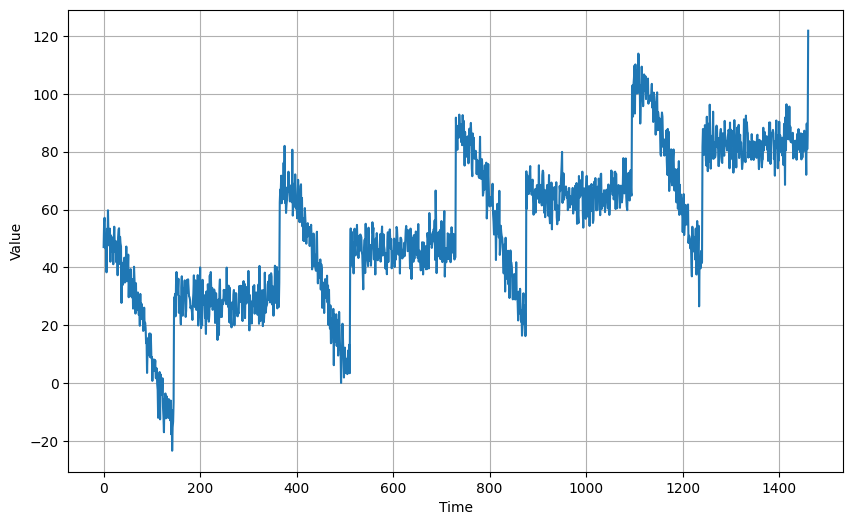

In [4]:
time = np.arange( 4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend( time, slope) + seasonality( time, period=365, amplitude=amplitude)

series += noise( time, noise_level)

plot_series( time, series)

In [5]:
split_time = 1000

time_train = time[ :split_time]
x_train = series[ :split_time]

time_valid = time[ split_time:]
x_valid = series[ split_time:]

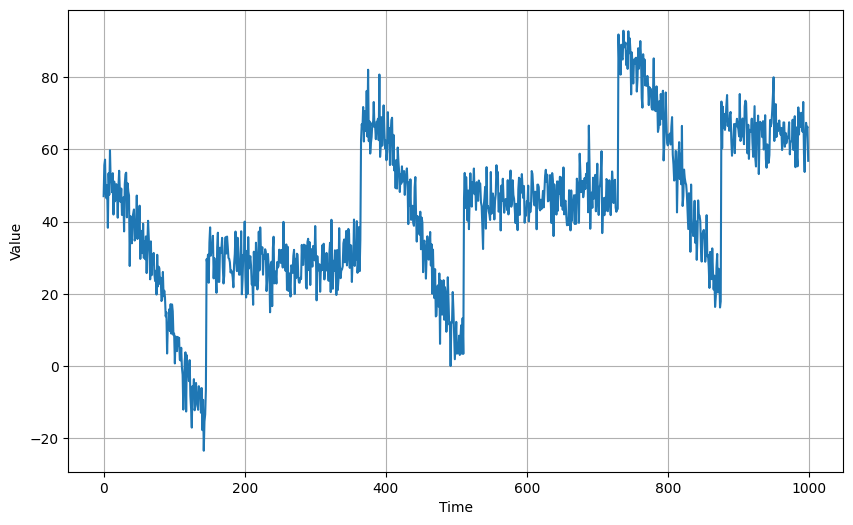

In [6]:
plot_series( time_train, x_train)

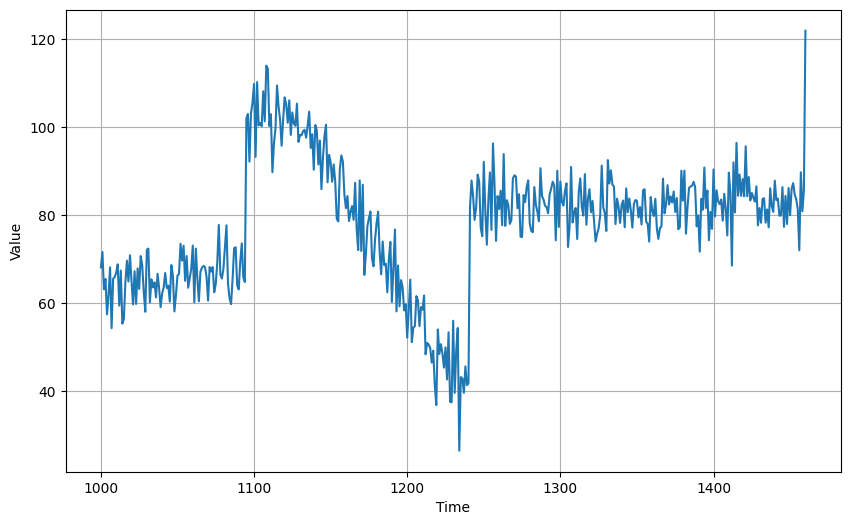

In [7]:
plot_series( time_valid, x_valid)

In [8]:
def windowed_dataset( series, window_size, batch_size, shuffle_buffer):
	dataset = tf.data.Dataset.from_tensor_slices( series)
	
	dataset = dataset.window( window_size + 1, shift=1, drop_remainder=True)

	dataset = dataset.flat_map( lambda window: window.batch( window_size + 1))

	dataset = dataset.map( lambda window: ( window[ :-1], window[ -1]))

	dataset = dataset.shuffle( shuffle_buffer)

	dataset = dataset.batch( batch_size).prefetch( 1)

	return dataset

In [9]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [10]:
dataset = windowed_dataset( x_train, window_size, batch_size, shuffle_buffer_size)

In [11]:
model_baseline = tf.keras.models.Sequential( [
	tf.keras.layers.Dense( 10, input_shape=[ window_size], activation="relu"),
	tf.keras.layers.Dense( 10, activation="relu"),
	tf.keras.layers.Dense( 1)
])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model_baseline.compile(
	loss="mse",
	optimizer=tf.keras.optimizers.SGD( learning_rate=1e-6, momentum=0.9)
)

In [13]:
model_baseline.fit(
	dataset,
	epochs=100,
	verbose=0
)

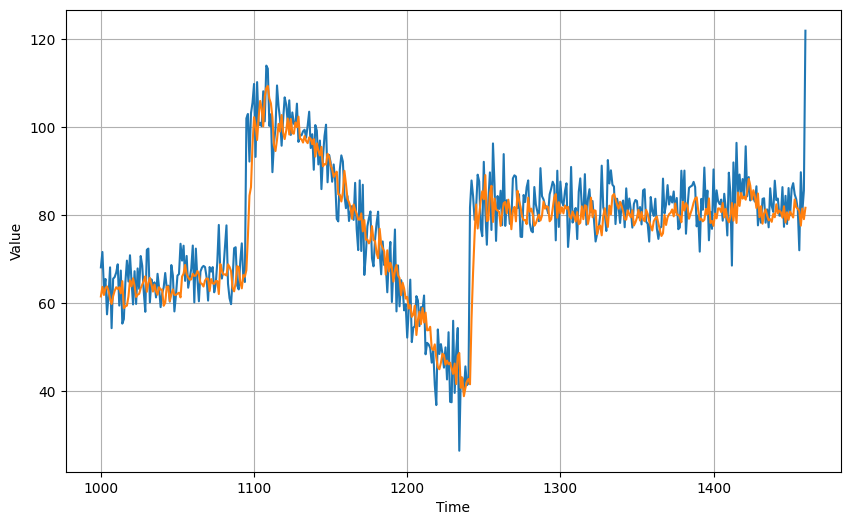

In [14]:
forecast = []

for time in range( len( series) - window_size):
	forecast.append( model_baseline.predict( series[ time:time + window_size][ np.newaxis], verbose=0))

forecast = forecast[ split_time - window_size:]

results = np.array( forecast).squeeze()

plot_series( time_valid, ( x_valid, results))

In [15]:
print( tf.keras.metrics.mean_squared_error( x_valid, results).numpy())
print( tf.keras.metrics.mean_absolute_error( x_valid, results).numpy())

49.00226
5.142714


In [16]:
model_tune = tf.keras.models.Sequential( [
	tf.keras.layers.Dense( 10, input_shape=[ window_size], activation="relu"),
	tf.keras.layers.Dense( 10, activation="relu"),
	tf.keras.layers.Dense( 1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
	lambda epoch: 1e-8 * 10 ** ( epoch / 20)
)

optimizer = tf.keras.optimizers.SGD( momentum=0.9)

model_tune.compile(
	loss="mse",
	optimizer=optimizer
)

history = model_tune.fit(
	dataset,
	epochs=100,
	callbacks=[ lr_schedule],
	verbose=0
)

(1e-08, 0.001, 0.0, 300.0)

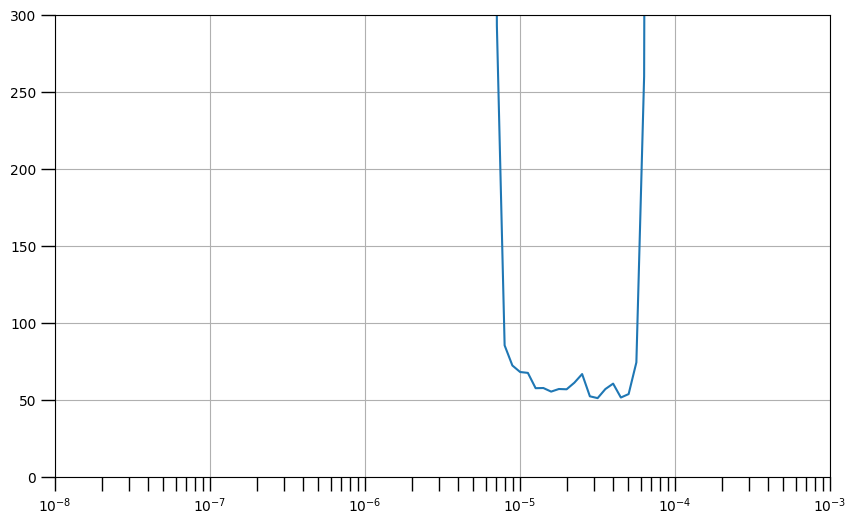

In [17]:
lrs = 1e-8 * ( 10 ** ( np.arange( 100) / 20))

plt.figure( figsize=( 10, 6))

plt.grid( True)

plt.semilogx( lrs, history.history[ "loss"])

plt.tick_params( "both", length=10, width=1, which="both")

plt.axis( [ 1e-8, 1e-3, 0, 300])

In [18]:
model_final = tf.keras.models.Sequential( [
	tf.keras.layers.Dense( 10, input_shape=[ window_size], activation="relu"),
	tf.keras.layers.Dense( 10, activation="relu"),
	tf.keras.layers.Dense( 1)
])

optimizer = tf.keras.optimizers.SGD(
	learning_rate=4e-6,
	momentum=0.9
)

model_final.compile(
	loss="mse",
	optimizer=optimizer
)

history = model_final.fit(
	dataset,
	epochs=100,
	verbose=0
)

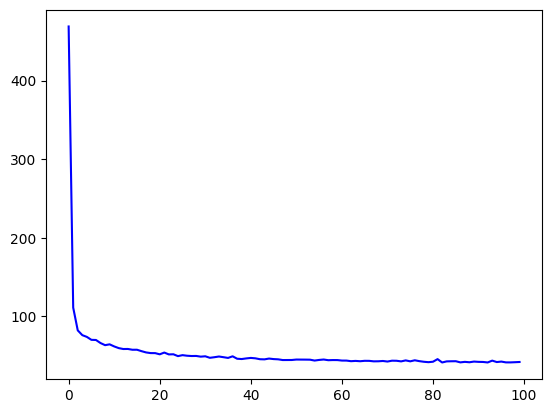

In [19]:
loss = history.history[ "loss"]
epochs = range( len( loss))
plt.plot( epochs, loss, "b", label="Training Loss")
plt.show()

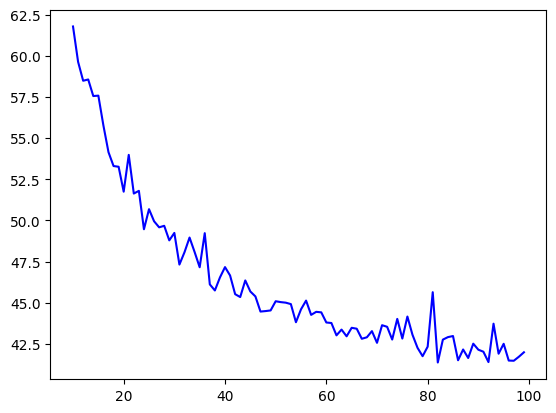

In [20]:
loss = history.history[ "loss"]
epochs = range( 10, len( loss))
plot_loss = loss[ 10:]
plt.plot( epochs, plot_loss, "b", label="Training Loss")
plt.show()

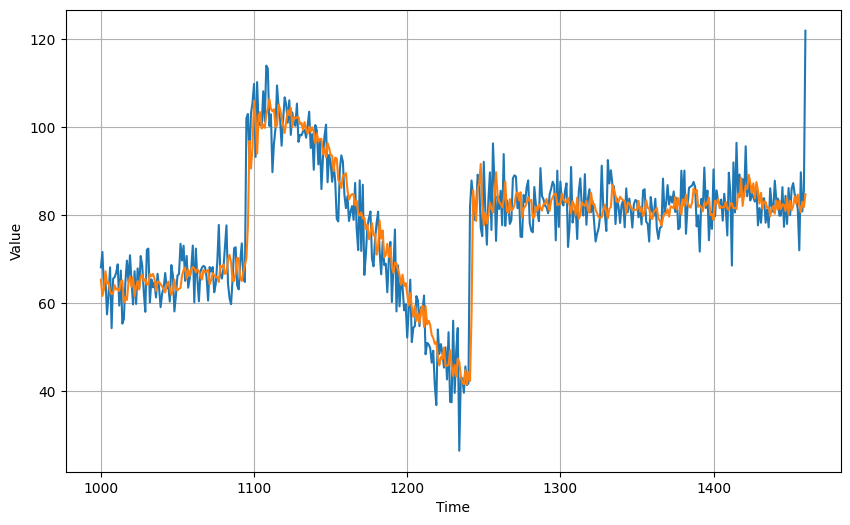

In [21]:
forecast = []

for time in range( len( series) - window_size):
	forecast.append( model_final.predict( series[ time:time + window_size][ np.newaxis], verbose=0))

forecast = forecast[ split_time - window_size:]

results = np.array( forecast).squeeze()

plot_series( time_valid, ( x_valid, results))

In [22]:
print( tf.keras.metrics.mean_squared_error( x_valid, results).numpy())
print( tf.keras.metrics.mean_absolute_error( x_valid, results).numpy())

43.863235
4.7929115
